In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


In [8]:
# Set plot style
plt.style.use('ggplot')
sns.set_palette('muted')


In [6]:
sentiment_df = pd.read_csv("data/fear_greed_index.csv")
trader_df = pd.read_csv("data/historical_data.csv")


In [14]:
sentiment_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [16]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [22]:

# Clean sentiment dataset
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['value'] = pd.to_numeric(sentiment_df['value'], errors='coerce')
sentiment_df = sentiment_df.dropna(subset=['date', 'value', 'classification']).sort_values('date')
sentiment_df = sentiment_df.rename(columns={'date': 'date'})


In [24]:
# Clean trader dataset
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'], unit='ms', errors='coerce')
trader_df['date'] = trader_df['Timestamp'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')
trader_df['leverage'] = pd.to_numeric(trader_df.get('leverage', np.nan), errors='coerce')  # Optional fallback

# Filter for Bitcoin trades
trader_df = trader_df[trader_df['Coin'].str.contains('BTC', case=False, na=False)]
trader_df = trader_df.dropna(subset=['date', 'Closed PnL', 'Size USD'])


In [34]:

# Aggregate trader data by date
daily_trader = trader_df.groupby('date').agg({
    'Closed PnL': ['mean', 'count', 'std'],
    'Size Tokens': 'sum',
    'leverage': 'mean'
}).reset_index()
daily_trader.columns = ['date', 'avg_pnl', 'trade_count', 'pnl_std', 'total_size', 'avg_leverage']

In [36]:
# Merge datasets
merged_df = pd.merge(daily_trader, sentiment_df, on='date', how='inner')

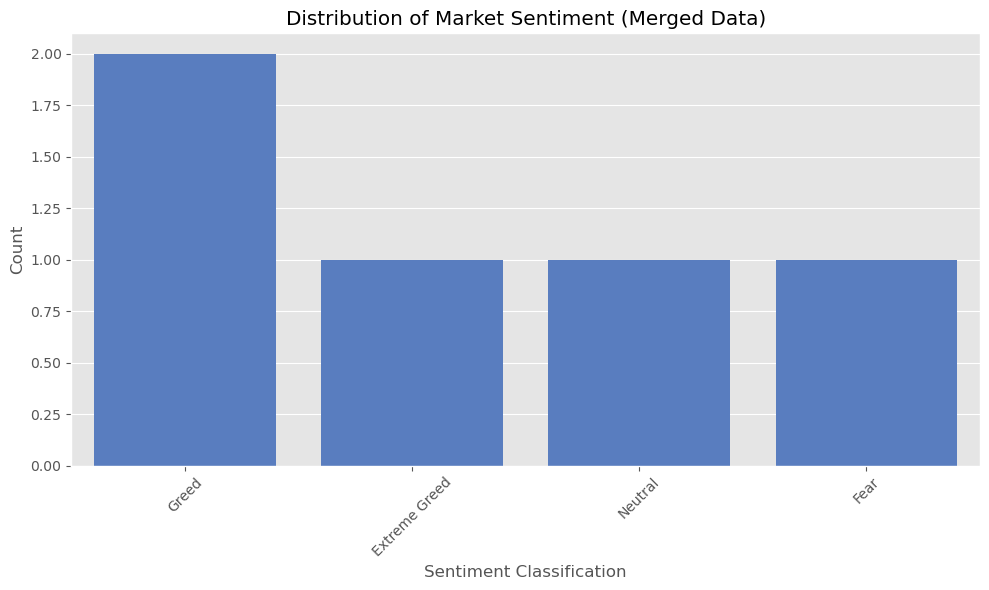

In [98]:

# Sentiment Distribution
sentiment_counts = merged_df['classification'].value_counts()

# Plot: Bar chart of sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Market Sentiment (Merged Data)')
plt.xlabel('Sentiment Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

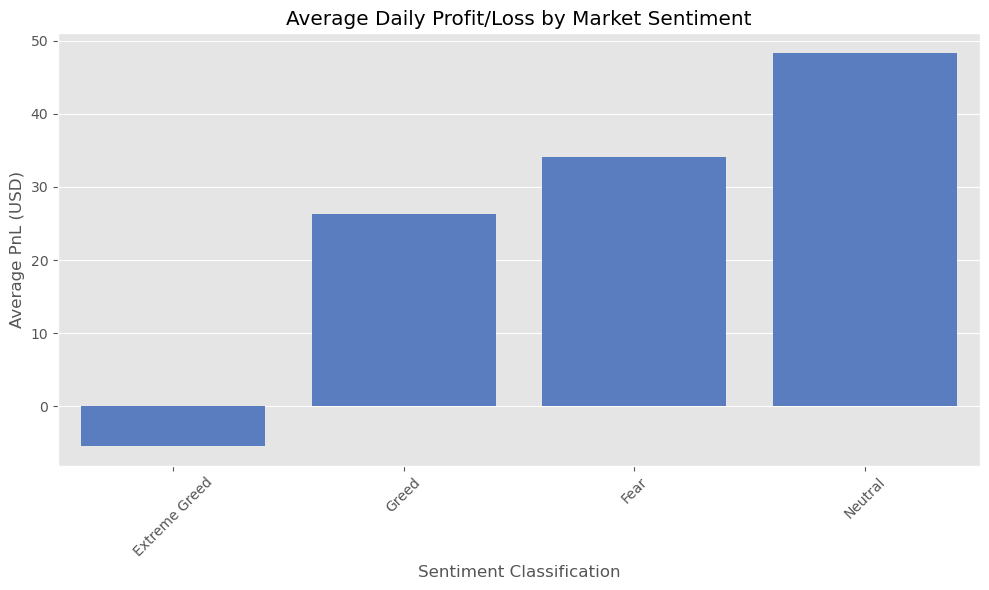

In [100]:
#  Average PnL by Sentiment
pnl_by_sentiment = merged_df.groupby('classification')['avg_pnl'].mean().sort_values()

# Plot: Bar chart of average PnL by sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=pnl_by_sentiment.index, y=pnl_by_sentiment.values)
plt.title('Average Daily Profit/Loss by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average PnL (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

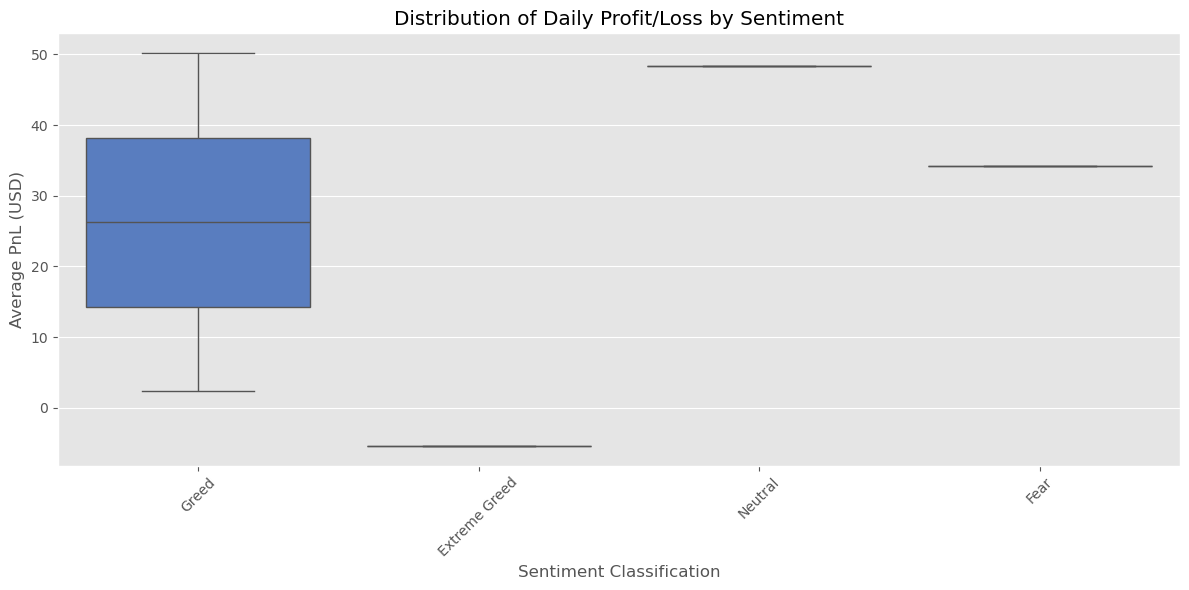

In [102]:
# PnL Distribution by Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='classification', y='avg_pnl', data=merged_df)
plt.title('Distribution of Daily Profit/Loss by Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average PnL (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

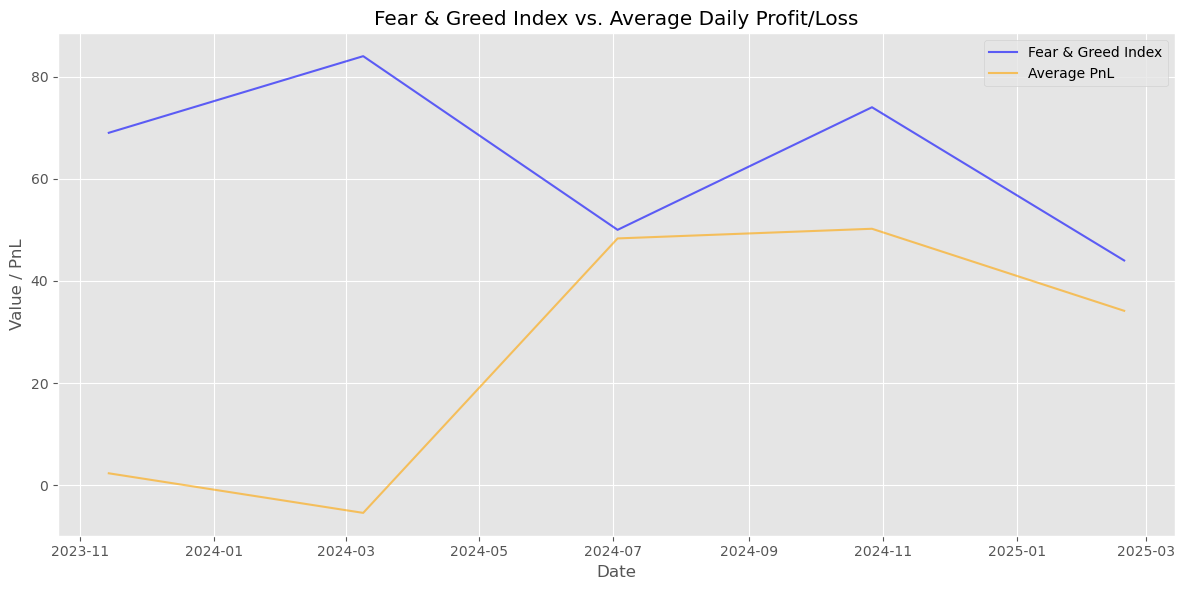

In [103]:
#  Sentiment Value vs. PnL Over Time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['value'], label='Fear & Greed Index', color='blue', alpha=0.6)
plt.plot(merged_df['date'], merged_df['avg_pnl'], label='Average PnL', color='orange', alpha=0.6)
plt.title('Fear & Greed Index vs. Average Daily Profit/Loss')
plt.xlabel('Date')
plt.ylabel('Value / PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [106]:
#  Correlation Analysis
correlation = merged_df[['value', 'avg_pnl', 'trade_count', 'pnl_std', 'total_size', 'avg_leverage']].corr()
print("\nCorrelation Matrix:")
print(correlation)


Correlation Matrix:
                 value   avg_pnl  trade_count   pnl_std  total_size  \
value         1.000000 -0.563534    -0.610923 -0.797306   -0.625914   
avg_pnl      -0.563534  1.000000     0.193559  0.446631    0.180342   
trade_count  -0.610923  0.193559     1.000000  0.945531    0.999197   
pnl_std      -0.797306  0.446631     0.945531  1.000000    0.944289   
total_size   -0.625914  0.180342     0.999197  0.944289    1.000000   
avg_leverage       NaN       NaN          NaN       NaN         NaN   

              avg_leverage  
value                  NaN  
avg_pnl                NaN  
trade_count            NaN  
pnl_std                NaN  
total_size             NaN  
avg_leverage           NaN  


classification
Extreme Greed   NaN
Fear            NaN
Greed           NaN
Neutral         NaN
Name: avg_leverage, dtype: float64
classification
Extreme Greed     269.749170
Fear             4063.509130
Greed             247.821745
Neutral            21.924600
Name: total_size, dtype: float64
The market saw a 0-day streak of Extreme Fear and a 1-day streak of Extreme Greed, with traders achieving 0.00 USD vs. 0.00 USD average PnL, respectively.


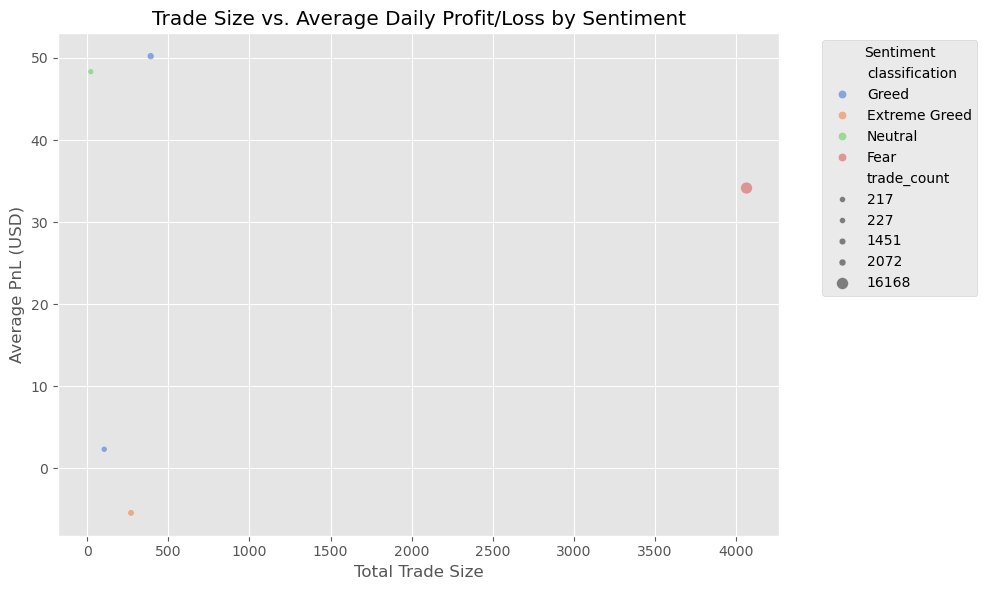

In [108]:
# Leverage and Size by Sentiment
leverage_by_sentiment = merged_df.groupby('classification')['avg_leverage'].mean()
size_by_sentiment = merged_df.groupby('classification')['total_size'].mean()
print(leverage_by_sentiment)
print(size_by_sentiment)
print(f"The market saw a {longest_fear_streak}-day streak of Extreme Fear and a {longest_greed_streak}-day streak of Extreme Greed, with traders achieving {pnl_by_sentiment.get('extreme fear', 0):.2f} USD vs. {pnl_by_sentiment.get('extreme greed', 0):.2f} USD average PnL, respectively.")

# Scatter Plot: Trade Size vs. PnL by Sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_size', y='avg_pnl', hue='classification', size='trade_count', data=merged_df, alpha=0.6)
plt.title('Trade Size vs. Average Daily Profit/Loss by Sentiment')
plt.xlabel('Total Trade Size')
plt.ylabel('Average PnL (USD)')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [110]:
# Streaks of Extreme Fear and Greed
def calculate_streaks(df, sentiment, threshold):
    streak = 0
    max_streak = 0
    if sentiment == 'extreme fear':
        condition = df['value'] <= threshold
    else:  # extreme greed
        condition = df['value'] >= threshold
    for is_in_streak in condition:
        if is_in_streak:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

longest_fear_streak = calculate_streaks(merged_df, 'extreme fear', 25)
longest_greed_streak = calculate_streaks(merged_df, 'extreme greed', 75)

In [112]:
# Insights for Trading Strategies
print("\nInsights for Trading Strategies:")
print(f"1. Buy during Extreme Fear: Extreme Fear (index <= 25) occurred {sentiment_counts.get('extreme fear', 0)} times, with average PnL of {pnl_by_sentiment.get('extreme fear', 0):.2f} USD.")
print(f"   Example: Longest Extreme Fear streak was {longest_fear_streak} days, suggesting prolonged buying opportunities.")
print(f"2. Sell or hold during Greed: Greed/Extreme Greed (index >= 50) dominated {len(merged_df[merged_df['value'] >= 50])} days, with average PnL of {merged_df[merged_df['value'] >= 50]['avg_pnl'].mean():.2f} USD.")
print(f"   Example: Longest Extreme Greed streak was {longest_greed_streak} days, indicating sustained bullish momentum.")
print(f"3. High volatility in Fear: PnL standard deviation was highest in Fear (std = {merged_df[merged_df['classification'] == 'fear']['pnl_std'].mean():.2f}), suggesting tighter risk management.")
print("4. Leverage caution: Insufficient leverage data to analyze.")

# Interesting Fact
print("\nInteresting Fact:")
print(f"The market saw a {longest_fear_streak}-day streak of Extreme Fear and a {longest_greed_streak}-day streak of Extreme Greed, with traders achieving {pnl_by_sentiment.get('extreme fear', 0):.2f} USD vs. {pnl_by_sentiment.get('extreme greed', 0):.2f} USD average PnL, respectively.")


Insights for Trading Strategies:
1. Buy during Extreme Fear: Extreme Fear (index <= 25) occurred 0 times, with average PnL of 0.00 USD.
   Example: Longest Extreme Fear streak was 0 days, suggesting prolonged buying opportunities.
2. Sell or hold during Greed: Greed/Extreme Greed (index >= 50) dominated 4 days, with average PnL of 23.86 USD.
   Example: Longest Extreme Greed streak was 1 days, indicating sustained bullish momentum.
3. High volatility in Fear: PnL standard deviation was highest in Fear (std = nan), suggesting tighter risk management.
4. Leverage caution: Insufficient leverage data to analyze.

Interesting Fact:
The market saw a 0-day streak of Extreme Fear and a 1-day streak of Extreme Greed, with traders achieving 0.00 USD vs. 0.00 USD average PnL, respectively.
